In [ ]:
# 1st step - Read data and sample to training and validation.
# 2nd step - trim down the dataset for certain modeling (use linear/log regression to do the initial feature selection)
# 3rd step - build models and compare and choose the best one based on validation
# 4th step - Score all the data and output

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib, re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
#nbayes = MultinomialNB()
#nbayes.fit(sms_messages_train, labels_train)
#accuracy=nbayes.score(sms_messages_test,labels_test)


In [350]:
# import data
Profile_fullset=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\Profile_fullset_noDup.csv")
Profile_activeset=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\Profile_activeset_noDup.csv")
RoadService_activeset=pd.read_csv("C:\Mark_Mao\MLAL_capstone\CleanSet\RoadService_activeset_noDup.csv")
#check
print(Profile_fullset.info())
print(Profile_activeset.info())
print(RoadService_activeset.info())
#print(list(Profile_fullset.columns) )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9665 entries, 0 to 9664
Data columns (total 64 columns):
Unnamed: 0                          9665 non-null int64
Individual Key                      9665 non-null float64
Household Key                       9665 non-null float64
Voluntary Cancel Flag               9665 non-null int64
m_PlusMember                        9665 non-null int64
FSV CMSI Flag                       9665 non-null object
FSV Credit Card Flag                9665 non-null object
FSV Deposit Program Flag            9665 non-null object
FSV Home Equity Flag                9665 non-null object
FSV ID Theft Flag                   9665 non-null object
FSV Mortgage Flag                   9665 non-null object
INS Client Flag                     9665 non-null object
TRV Globalware Flag                 9665 non-null object
Months from Join to Cancel          9665 non-null float64
m_ProfileMissing                    9665 non-null int64
m_TenureYr                          966

In [351]:
# Replace Y/N target values with 0/1 for modeling
Profile_activeset['FSV CMSI Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
Profile_activeset['FSV Credit Card Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
Profile_activeset['FSV Deposit Program Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
Profile_activeset['FSV Home Equity Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
Profile_activeset['FSV ID Theft Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
Profile_activeset['FSV Mortgage Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
Profile_activeset['INS Client Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
Profile_activeset['TRV Globalware Flag'].replace(('Y', 'N'), (1, 0), inplace=True)
print(Profile_activeset[['Individual Key','Household Key','Voluntary Cancel Flag','m_PlusMember','FSV CMSI Flag','FSV Credit Card Flag','FSV Deposit Program Flag','FSV Home Equity Flag','FSV ID Theft Flag','FSV Mortgage Flag','INS Client Flag','TRV Globalware Flag']].head(10))

   Individual Key  Household Key  Voluntary Cancel Flag  m_PlusMember  \
0     212321856.0     99993288.0                      0             0   
1     212320920.0    100035899.0                      0             0   
2     212312283.0      4898837.0                      0             0   
3     212310962.0      1963199.0                      0             1   
4     212308805.0      8548363.0                      0             0   
5     212308372.0     10416039.0                      0             0   
6     212306183.0     13240184.0                      0             1   
7     212303147.0    100020029.0                      0             0   
8     212302836.0       564069.0                      0             0   
9     212294716.0     10472486.0                      0             0   

   FSV CMSI Flag  FSV Credit Card Flag  FSV Deposit Program Flag  \
0              0                     0                         0   
1              1                     0                      

In [352]:
cancel_train, cancel_test = train_test_split(Profile_fullset, test_size=0.3,random_state=0)
prod_train, prod_test = train_test_split(Profile_activeset, test_size=0.3,random_state=0)
RS_train, RS_test = train_test_split(Profile_fullset, test_size=0.3,random_state=0)

In [353]:
print(cancel_train['Household Key'].describe())
print(cancel_test['Household Key'].describe())
#print(prod_train['Household Key'].describe())
#print(prod_test['Household Key'].describe())

count    6.765000e+03
mean     1.492561e+07
std      1.931985e+07
min      8.750000e+02
25%      4.256561e+06
50%      9.999165e+06
75%      1.640954e+07
max      1.000791e+08
Name: Household Key, dtype: float64
count    2.900000e+03
mean     1.489193e+07
std      1.905314e+07
min      9.690000e+02
25%      4.596166e+06
50%      9.861311e+06
75%      1.634915e+07
max      1.000719e+08
Name: Household Key, dtype: float64


In [354]:
# X_list_cancel is the explantory variables list for probability of 'Voluntary Cancel Flag'
# X_list is the explantory variables list for all other classification models


X_list_cancel=[
    'm_ProfileMissing', 'm_TenureYr', 
        'm_OccupationMissing', 
         'm_IncomeMissing', 
        'm_HomeownerFlag', 'm_RenterFlag', 'm_memberage',
        'm_DwellMissing', 'm_nChild', 'm_LenResidence', 
         'm_Income', 'm_Credit', 
        'm_MailRespondYes', 'm_NoChild', 
        'm_PrimaryMember', 'm_OptIn_Publication', 'm_CashCallYes',
        'm_MosaicMIssing', 'm_NewMover', 'Occ_Blue_Collar', 
        'Occ_Management', 'Occ_OfficeAdmin', 'Occ_Other', 
        'Occ_Professional', 'Occ_Retired', 'Occ_Sales',
    'Ed_Completed College', 
        'Ed_Graduated School', 'Ed_High School', 
        'Ed_Some College', 'Mosaic_Bourgeois Prosperity', 
        'Mosaic_Career and Family', 'Mosaic_Comfortable Retirement',
        'Mosaic_Hard Working Blue Collar', 'Mosaic_Low Income Elders',
        'Mosaic_Metropolitan Strugglers', 
        'Mosaic_Post Industrial Survivors', 
        'Mosaic_Routine Service Workers', 'Mosaic_Rural Inheritance',
        'Mosaic_Sophisticated Singles', 'm_AutoRenew', 'Dwell_MFDU', 
        'Dwell_POBOX', 'Dwell_SFDU'
]

X_list=['m_ProfileMissing', 'm_TenureYr', 
        'm_OccupationMissing', 
        'm_AgeMissing', 'm_IncomeMissing', 
        'm_HomeownerFlag', 'm_RenterFlag', 'm_memberage',
        'm_DwellMissing', 'm_nChild', 'm_LenResidence', 
         'm_Income', 'm_Credit', 
        'm_MailRespondYes', 'm_NoChild', 
        'm_PrimaryMember', 'm_OptIn_Publication', 'm_CashCallYes',
        'm_MosaicMIssing', 'm_NewMover', 'Occ_Blue_Collar', 
        'Occ_Management', 'Occ_OfficeAdmin', 'Occ_Other', 
        'Occ_Professional', 'Occ_Retired', 'Occ_Sales', 
        'Occ_Technical', 'Ed_Completed College', 
        'Ed_Graduated School', 'Ed_High School', 
        'Ed_Some College', 'Mosaic_Bourgeois Prosperity', 
        'Mosaic_Career and Family', 'Mosaic_Comfortable Retirement',
        'Mosaic_Hard Working Blue Collar', 'Mosaic_Low Income Elders',
        'Mosaic_Metropolitan Strugglers', 
        'Mosaic_Post Industrial Survivors', 
        'Mosaic_Routine Service Workers', 'Mosaic_Rural Inheritance',
        'Mosaic_Sophisticated Singles', 'm_AutoRenew', 'Dwell_MFDU', 
        'Dwell_POBOX', 'Dwell_SFDU'  
]

X_list2=['m_ProfileMissing', 'm_TenureYr', 
        'm_OccupationMissing',  'm_IncomeMissing', 
        'm_HomeownerFlag', 'm_RenterFlag', 'm_memberage',
        'm_nChild', 'm_LenResidence', 
         'm_Income', 'm_Credit', 
        'm_MailRespondYes', 'm_NoChild', 
        'm_PrimaryMember', 'm_OptIn_Publication', 'm_CashCallYes',
         'm_NewMover', 'Occ_Blue_Collar', 
        'Occ_Management', 'Occ_OfficeAdmin', 'Occ_Other', 
        'Occ_Professional', 'Occ_Retired', 'Occ_Sales', 
        'Occ_Technical', 'Ed_Completed College', 
        'Ed_Graduated School', 'Ed_High School', 
        'Ed_Some College', 'Mosaic_Bourgeois Prosperity', 
        'Mosaic_Career and Family', 'Mosaic_Comfortable Retirement',
        'Mosaic_Hard Working Blue Collar', 'Mosaic_Low Income Elders',
        'Mosaic_Metropolitan Strugglers', 
        'Mosaic_Post Industrial Survivors', 
        'Mosaic_Routine Service Workers', 'Mosaic_Rural Inheritance',
        'Mosaic_Sophisticated Singles', 'm_AutoRenew', 'Dwell_MFDU', 
        'Dwell_POBOX', 'Dwell_SFDU'  
]

In [355]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


In [356]:
################  Probability of Voluntary Cancallation #########

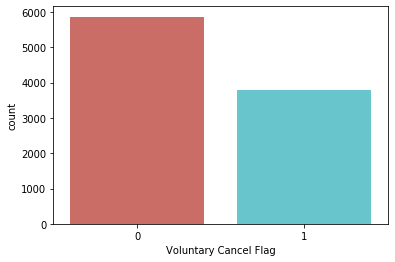

<Figure size 432x288 with 0 Axes>

In [357]:
sns.countplot(x='Voluntary Cancel Flag',data=Profile_fullset,palette='hls')
plt.show()
plt.savefig('count_plot')

In [358]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm

Modeling_X=cancel_train[X_list_cancel]
Test_X=cancel_test[X_list_cancel]

X_train = sm.add_constant(Modeling_X)
y_train = cancel_train.loc[:,'Voluntary Cancel Flag']

X_test = sm.add_constant(Test_X)
y_test = cancel_test.loc[:,'Voluntary Cancel Flag']

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

#logreg = LogisticRegression()
#logreg.fit(X_train, )


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


         Current function value: 0.419301
         Iterations: 35
                                           Results: Logit
Model:                         Logit                           Pseudo R-squared:           0.374    
Dependent Variable:            Voluntary Cancel Flag           AIC:                        5759.1449
Date:                          2020-05-30 10:19                BIC:                        6052.3842
No. Observations:              6765                            Log-Likelihood:             -2836.6  
Df Model:                      42                              LL-Null:                    -4532.3  
Df Residuals:                  6722                            LLR p-value:                0.0000   
Converged:                     0.0000                          Scale:                      1.0000   
No. Iterations:                35.0000                                                              
--------------------------------------------------------------------

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.72      0.97      0.82      1759
           1       0.89      0.41      0.56      1141

    accuracy                           0.75      2900
   macro avg       0.80      0.69      0.69      2900
weighted avg       0.79      0.75      0.72      2900

Accuracy of this classifier on test set: 0.75


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7540622770241299


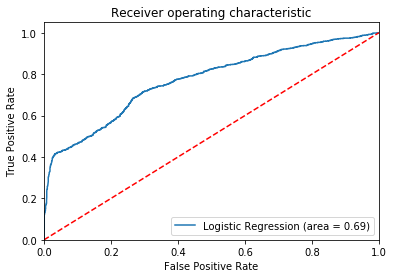

In [359]:
###### Fit on logistic regression  ##########

X_list_cancel_final=[
    'm_TenureYr', 
        'm_OccupationMissing', 'm_IncomeMissing', 
        'm_HomeownerFlag', 'm_memberage',
      'm_LenResidence', 'Occ_Retired',
         'm_Income', 
        'm_PrimaryMember', 'm_OptIn_Publication', 
        'm_NewMover', 
    'Ed_Completed College',
]

Modeling_X=cancel_train[X_list_cancel_final]
Test_X=cancel_test[X_list_cancel_final]

X_train = sm.add_constant(Modeling_X)
y_train = cancel_train.loc[:,'Voluntary Cancel Flag']

X_test = sm.add_constant(Test_X)
y_test = cancel_test.loc[:,'Voluntary Cancel Flag']

logreg = LogisticRegression()
logreg.fit(X_train,y_train )

y_pred = logreg.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

y_pred = logreg.predict(X_test)
print('Accuracy of this classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, y, cv=5)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [360]:
###### Fit on SGD  ##########
from sklearn.linear_model import SGDClassifier

SGDclf = SGDClassifier(loss="squared_hinge", penalty="l2", max_iter=20)
SGDclf.fit(X, y)

y_pred = SGDclf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

y_pred = SGDclf.predict(X_test)
print('Accuracy of this classifier on test set: {:.2f}'.format(SGDclf.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(SGDclf, X, y, cv=5)
print(scores.mean())

              precision    recall  f1-score   support

           0       0.66      0.86      0.74      1759
           1       0.58      0.31      0.40      1141

    accuracy                           0.64      2900
   macro avg       0.62      0.58      0.57      2900
weighted avg       0.63      0.64      0.61      2900

Accuracy of this classifier on test set: 0.64
0.614696174224097


C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceW

In [361]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(max_depth=30, min_samples_split=100,min_samples_leaf=50,random_state=0)
print(cross_val_score(DT, X, y, cv=5))

RF = RandomForestClassifier(n_estimators=20, max_depth=30,min_samples_split=100,min_samples_leaf=50, random_state=0)
print(cross_val_score(RF, X, y, cv=5))

ET = ExtraTreesClassifier(n_estimators=20, max_depth=30,min_samples_split=100,min_samples_leaf=50, random_state=0)
print(cross_val_score(ET, X, y, cv=5))

[0.80558428 0.8319545  0.8256596  0.82608696 0.83333333]
[0.74974147 0.83764219 0.8189343  0.81625259 0.82971014]
[0.73319545 0.81282316 0.80393171 0.813147   0.79037267]


In [362]:
######### For probabiliy of voluntary cancallation - Decision tree classifier is best ######

DT.fit(X_train, y_train)
y_train_pred= pd.DataFrame(DT.predict_proba(X_train), columns = ['Pred_Prob_Voluntary_Cancel0','Pred_Prob_Voluntary_Cancel1']) 
y_test_pred = pd.DataFrame(DT.predict_proba(X_test), columns = ['Pred_Prob_Voluntary_Cancel0','Pred_Prob_Voluntary_Cancel1']) 

#print(y_test_pred.head(10))
cancel_train.reset_index(drop=True, inplace=True)
y_train_pred.reset_index(drop=True, inplace=True)
cancel_test.reset_index(drop=True, inplace=True)
y_test_pred.reset_index(drop=True, inplace=True)
cancel_train_out=pd.concat([cancel_train, y_train_pred],axis=1)
cancel_test_out=pd.concat([cancel_test, y_test_pred],axis=1)

cancel_out=pd.concat([cancel_train_out, cancel_test_out],axis=0)
# only keep the active member prediction for segementation.
cancel_out_active=cancel_out[cancel_out['Voluntary Cancel Flag']==0]
#cancel_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\cancel_out.csv')
print(cancel_out_active['Household Key'].describe())

count    5.867000e+03
mean     1.504961e+07
std      1.911199e+07
min      8.750000e+02
25%      4.596366e+06
50%      1.016684e+07
75%      1.647581e+07
max      1.000791e+08
Name: Household Key, dtype: float64


In [364]:
########### Fit on  Plus/Premier membership vs basic  #############

Modeling_X=prod_train[X_list]
Test_X=prod_test[X_list]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'m_PlusMember']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'m_PlusMember']

logit_model_plus=sm.Logit(y_train,X_train)
result=logit_model_plus.fit()
print(result.summary2())

# It is not an easy target to predict with what fields we have. Will not persue.

         Current function value: 0.591102
         Iterations: 35
                                        Results: Logit
Model:                         Logit                      Pseudo R-squared:           0.012    
Dependent Variable:            m_PlusMember               AIC:                        4940.1301
Date:                          2020-05-30 10:20           BIC:                        5211.8989
No. Observations:              4106                       Log-Likelihood:             -2427.1  
Df Model:                      42                         LL-Null:                    -2456.4  
Df Residuals:                  4063                       LLR p-value:                0.045855 
Converged:                     0.0000                     Scale:                      1.0000   
No. Iterations:                35.0000                                                         
-----------------------------------------------------------------------------------------------
               

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


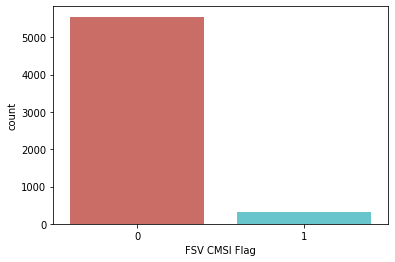

<Figure size 432x288 with 0 Axes>

In [365]:
sns.countplot(x='FSV CMSI Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')

In [366]:
########### Feature selection on  FSV CMSI Flag  #############

Modeling_X=prod_train[X_list]
Test_X=prod_test[X_list]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV CMSI Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV CMSI Flag']

logit_model_CMSI=sm.Logit(y_train,X_train)
result=logit_model_CMSI.fit()
print(result.summary2())

         Current function value: 0.194282
         Iterations: 35
                                                Results: Logit
Model:                              Logit                           Pseudo R-squared:                0.034    
Dependent Variable:                 FSV CMSI Flag                   AIC:                             1681.4443
Date:                               2020-05-30 10:20                BIC:                             1953.2131
No. Observations:                   4106                            Log-Likelihood:                  -797.72  
Df Model:                           42                              LL-Null:                         -825.96  
Df Residuals:                       4063                            LLR p-value:                     0.066937 
Converged:                          0.0000                          Scale:                           1.0000   
No. Iterations:                     35.0000                                                   

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1657
           1       0.00      0.00      0.00       104

    accuracy                           0.94      1761
   macro avg       0.47      0.50      0.48      1761
weighted avg       0.89      0.94      0.91      1761

Accuracy of this classifier on test set: 0.94
0.9476380719268344


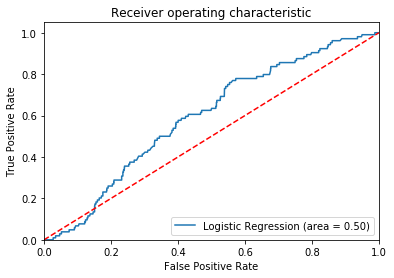

In [367]:

X_list_final=[
        'm_OccupationMissing','m_memberage',
      'm_LenResidence', 'Occ_Retired',
         'm_Income', 'Ed_High School'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV CMSI Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV CMSI Flag']

logregCMSI = LogisticRegression()
logregCMSI.fit(X_train,y_train )

y_pred = logregCMSI.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(logregCMSI.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logregCMSI, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logregCMSI.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregCMSI.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [368]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

DT_CMSI = DecisionTreeClassifier(max_depth=15, min_samples_split=50,min_samples_leaf=20,random_state=0)
print(cross_val_score(DT_CMSI, X_train, y_train, cv=3))

RF_CMSI = RandomForestClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(RF_CMSI, X_train, y_train, cv=3))

ET_CMSI = ExtraTreesClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(ET_CMSI, X_train, y_train, cv=3))

# Will use Decision tree for better accuracy and 

[0.94886779 0.94886779 0.9495614 ]
[0.94886779 0.94886779 0.9495614 ]
[0.94886779 0.94886779 0.9495614 ]


In [369]:
######### For probabiliy of CMSI - Decision tree classifier is best ######
######### Overall this model is not good at predict CMSI=1 with the fields we have ##########
DT_CMSI.fit(X_train, y_train)
y_train_pred= pd.DataFrame(DT_CMSI.predict_proba(X_train), columns = ['Pred_Prob_CMSI0','Pred_Prob_CMSI1']) 
y_test_pred = pd.DataFrame(DT_CMSI.predict_proba(X_test), columns = ['Pred_Prob_CMSI0','Pred_Prob_CMSI1']) 
#print(y_test_pred.head(10))
prod_train.reset_index(drop=True, inplace=True)
y_train_pred.reset_index(drop=True, inplace=True)
prod_test.reset_index(drop=True, inplace=True)
y_test_pred.reset_index(drop=True, inplace=True)
prod_train_out=pd.concat([prod_train, y_train_pred],axis=1)
prod_test_out=pd.concat([prod_test, y_test_pred],axis=1)

#cancel_out=pd.concat([cancel_train_out, cancel_test_out],axis=0)
# only keep the active member prediction for segementation.
#cancel_out_active=cancel_out[cancel_out['Voluntary Cancel Flag']==0]
#prod_test_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out_check.csv')
#print(cancel_out_active['Household Key'].describe())

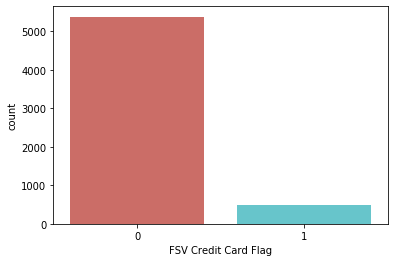

<Figure size 432x288 with 0 Axes>

In [370]:
sns.countplot(x='FSV Credit Card Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')

In [371]:
########### Feature selection on  Credit card Flag  #############

Modeling_X=prod_train[X_list]
Test_X=prod_test[X_list]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV Credit Card Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV Credit Card Flag']

logit_model_CC=sm.Logit(y_train,X_train)
result=logit_model_CC.fit()
print(result.summary2())

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.246257
         Iterations: 35
                                       Results: Logit
Model:                      Logit                        Pseudo R-squared:         0.098     
Dependent Variable:         FSV Credit Card Flag         AIC:                      2108.2590 
Date:                       2020-05-30 10:20             BIC:                      2380.0278 
No. Observations:           4106                         Log-Likelihood:           -1011.1   
Df Model:                   42                           LL-Null:                  -1121.3   
Df Residuals:               4063                         LLR p-value:              4.8563e-26
Converged:                  0.0000                       Scale:                    1.0000    
No. Iterations:             35.0000                                                          
---------------------------------------------------------------------------------------------
                                  

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1594
           1       0.00      0.00      0.00       167

    accuracy                           0.91      1761
   macro avg       0.45      0.50      0.48      1761
weighted avg       0.82      0.91      0.86      1761

Accuracy of this classifier on test set: 0.91
0.9223090166616866


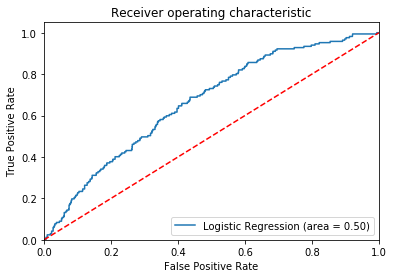

In [372]:
X_list_final=['m_TenureYr','m_memberage',
      'm_PrimaryMember', 'Ed_Graduated School',
         'm_Income', 'm_Credit','Ed_High School','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV Credit Card Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV Credit Card Flag']

logregCC = LogisticRegression()
logregCC.fit(X_train,y_train )

y_pred = logregCC.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(logregCC.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logregCC, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logregCC.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregCC.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [373]:
DT_CC = DecisionTreeClassifier(max_depth=15, min_samples_split=50,min_samples_leaf=20,random_state=0)
print(cross_val_score(DT_CC, X_train, y_train, cv=3))

RF_CC = RandomForestClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(RF_CC, X_train, y_train, cv=3))

ET_CC = ExtraTreesClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(ET_CC, X_train, y_train, cv=3))

# Will use Random Forest for better accruacy 

[0.91678832 0.92251462 0.91520468]
[0.92189781 0.92251462 0.92251462]
[0.92189781 0.92251462 0.92251462]


In [374]:
######### For probabiliy of credit card - Random Forest classifier is best ######

RF_CC.fit(X_train, y_train)
y_train_pred= pd.DataFrame(RF_CC.predict_proba(X_train), columns = ['Pred_Prob_CC0','Pred_Prob_CC1']) 
y_test_pred = pd.DataFrame(RF_CC.predict_proba(X_test), columns = ['Pred_Prob_CC0','Pred_Prob_CC1']) 
#print(y_test_pred.head(10))
prod_train.reset_index(drop=True, inplace=True)
y_train_pred.reset_index(drop=True, inplace=True)
prod_test.reset_index(drop=True, inplace=True)
y_test_pred.reset_index(drop=True, inplace=True)
prod_train_out=pd.concat([prod_train_out, y_train_pred],axis=1)
prod_test_out=pd.concat([prod_test_out, y_test_pred],axis=1)

#cancel_out=pd.concat([cancel_train_out, cancel_test_out],axis=0)
# only keep the active member prediction for segementation.
#cancel_out_active=cancel_out[cancel_out['Voluntary Cancel Flag']==0]
#prod_test_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out_check.csv')
#print(cancel_out_active['Household Key'].describe())

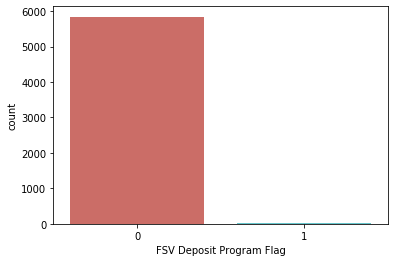

<Figure size 432x288 with 0 Axes>

In [375]:
sns.countplot(x= 'FSV Deposit Program Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')


In [376]:
########### Feature selection on  deposit Flag  #############

Modeling_X=prod_train[X_list]
Test_X=prod_test[X_list]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV Deposit Program Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV Deposit Program Flag']

logit_model_Depos=sm.Logit(y_train,X_train)
result=logit_model_Depos.fit()
print(result.summary2())


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


         Current function value: 0.024018
         Iterations: 35


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                                  Results: Logit
Model:                             Logit                                  Pseudo R-squared:               0.148   
Dependent Variable:                FSV Deposit Program Flag               AIC:                            283.2386
Date:                              2020-05-30 10:21                       BIC:                            555.0074
No. Observations:                  4106                                   Log-Likelihood:                 -98.619 
Df Model:                          42                                     LL-Null:                        -115.70 
Df Residuals:                      4063                                   LLR p-value:                    0.80004 
Converged:                         0.0000                                 Scale:                          1.0000  
No. Iterations:                    35.0000                                                                        
---------------

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1754
           1       0.00      0.00      0.00         7

    accuracy                           1.00      1761
   macro avg       0.50      0.50      0.50      1761
weighted avg       0.99      1.00      0.99      1761

Accuracy of this classifier on test set: 1.00
0.9956161709362279


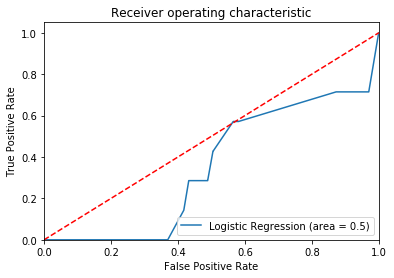

In [377]:
# no single field has low p-value -> will be a model with very limited predicitive power
# set p-value <25% to build the model.
X_list_final=['m_LenResidence','m_NewMover','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV Deposit Program Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV Deposit Program Flag']

logregdepos = LogisticRegression()
logregdepos.fit(X_train,y_train )

y_pred = logregdepos.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(logregdepos.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logregdepos, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logregdepos.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregdepos.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# AUC is showing that model is not doing better than a random guess.
# Here we may need to assign probability as the constant for every observation later.

In [378]:
DT_depos = DecisionTreeClassifier(max_depth=15, min_samples_split=50,min_samples_leaf=20,random_state=0)
print(cross_val_score(DT_depos, X_train, y_train, cv=3))

RF_depos = RandomForestClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(RF_depos, X_train, y_train, cv=3))

ET_depos = ExtraTreesClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(ET_depos, X_train, y_train, cv=3))

[0.99561724 0.99561724 0.99561404]
[0.99561724 0.99561724 0.99561404]
[0.99561724 0.99561724 0.99561404]


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1754
           1       0.00      0.00      0.00         7

    accuracy                           1.00      1761
   macro avg       0.50      0.50      0.50      1761
weighted avg       0.99      1.00      0.99      1761

Accuracy of this classifier on test set: 1.00
0.9956161709362279


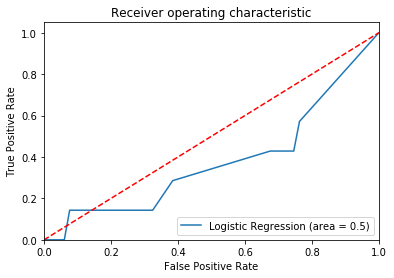

In [379]:
# no single field has low p-value -> will be a model with very limited predicitive power
# set p-value <25% to build the model.
X_list_final=['m_LenResidence','m_NewMover','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV Deposit Program Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV Deposit Program Flag']

RF_depos.fit(X_train,y_train )

y_pred = RF_depos.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(RF_depos.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(RF_depos, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, RF_depos.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RF_depos.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_depos_ROC')
plt.show()

# AUC is showing that model is doing worse than a random guess.
# Here will assign probability as the avg. constant for every observation later.

In [380]:
#print(y_train.describe())
#print(y_test.describe())
prod_train_out['Pred_Prob_Deposit1']=0.004384
prod_test_out['Pred_Prob_Deposit1']=0.003975
#prod_test_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out_check.csv')

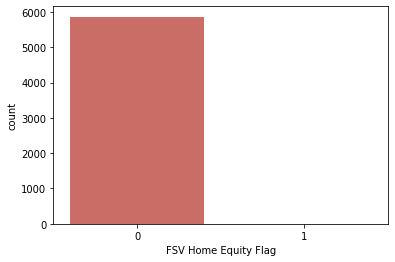

count    5867.000000
mean        0.000511
std         0.022609
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: FSV Home Equity Flag, dtype: float64


<Figure size 432x288 with 0 Axes>

In [381]:
sns.countplot(x= 'FSV Home Equity Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')

print(Profile_activeset['FSV Home Equity Flag'].describe())
# Will save the time for this and set the probability to be 0 (0.0005)

In [382]:
# Will save the time for this and set the probability to be (0.0005) (mathematically 0)
prod_train_out['Pred_Prob_HomeEquity1']=0.0005
prod_test_out['Pred_Prob_HomeEquity1']=0.0005

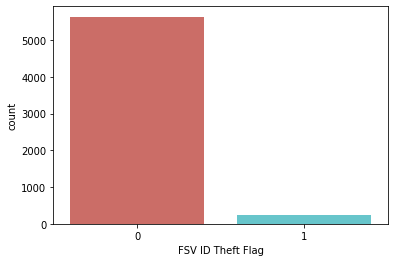

count    5867.000000
mean        0.039373
std         0.194497
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: FSV ID Theft Flag, dtype: float64


<Figure size 432x288 with 0 Axes>

In [383]:
sns.countplot(x='FSV ID Theft Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')

print(Profile_activeset['FSV ID Theft Flag'].describe())

In [384]:
Modeling_X=prod_train[X_list]
Test_X=prod_test[X_list]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV ID Theft Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV ID Theft Flag']

logit_model_IDT=sm.Logit(y_train,X_train)
result=logit_model_IDT.fit()
print(result.summary2())


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


         Current function value: 0.152669
         Iterations: 35
                                                    Results: Logit
Model:                                 Logit                              Pseudo R-squared:                  0.059     
Dependent Variable:                    FSV ID Theft Flag                  AIC:                               1339.7216 
Date:                                  2020-05-30 10:21                   BIC:                               1611.4904 
No. Observations:                      4106                               Log-Likelihood:                    -626.86   
Df Model:                              42                                 LL-Null:                           -666.40   
Df Residuals:                          4063                               LLR p-value:                       0.00046752
Converged:                             0.0000                             Scale:                             1.0000    
No. Iterations:            

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1687
           1       0.00      0.00      0.00        74

    accuracy                           0.96      1761
   macro avg       0.48      0.50      0.49      1761
weighted avg       0.92      0.96      0.94      1761

Accuracy of this classifier on test set: 0.96
0.9617634922667578


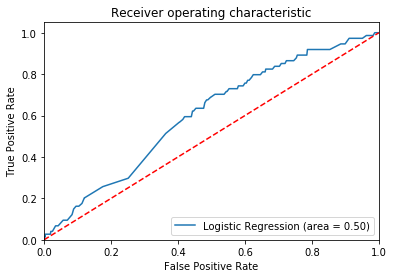

In [385]:
X_list_final=['m_TenureYr', 'm_PrimaryMember']

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'FSV ID Theft Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'FSV ID Theft Flag']

logregIDT = LogisticRegression()
logregIDT.fit(X_train,y_train )

y_pred = logregIDT.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(logregIDT.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logregIDT, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logregIDT.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregIDT.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [386]:
DT_IDT = DecisionTreeClassifier(max_depth=15, min_samples_split=50,min_samples_leaf=20,random_state=0)
print(cross_val_score(DT_IDT, X_train, y_train, cv=3))

RF_IDT = RandomForestClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(RF_IDT, X_train, y_train, cv=3))

ET_IDT = ExtraTreesClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(ET_IDT, X_train, y_train, cv=3))

# use decision tree for better balance of accuracy and simplicity

[0.96131387 0.9619883  0.9619883 ]
[0.96131387 0.9619883  0.9619883 ]
[0.96131387 0.9619883  0.9619883 ]


In [387]:
DT_IDT.fit(X_train, y_train)
y_train_pred= pd.DataFrame(DT_IDT.predict_proba(X_train), columns = ['Pred_Prob_IDtheft0','Pred_Prob_IDtheft1']) 
y_test_pred = pd.DataFrame(DT_IDT.predict_proba(X_test), columns = ['Pred_Prob_IDtheft0','Pred_Prob_IDtheft1']) 
#print(y_test_pred.head(10))
prod_train.reset_index(drop=True, inplace=True)
y_train_pred.reset_index(drop=True, inplace=True)
prod_test.reset_index(drop=True, inplace=True)
y_test_pred.reset_index(drop=True, inplace=True)
prod_train_out=pd.concat([prod_train_out, y_train_pred],axis=1)
prod_test_out=pd.concat([prod_test_out, y_test_pred],axis=1)

#cancel_out=pd.concat([cancel_train_out, cancel_test_out],axis=0)
# only keep the active member prediction for segementation.
#cancel_out_active=cancel_out[cancel_out['Voluntary Cancel Flag']==0]
prod_test_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out_check.csv')
#print(cancel_out_active['Household Key'].describe())

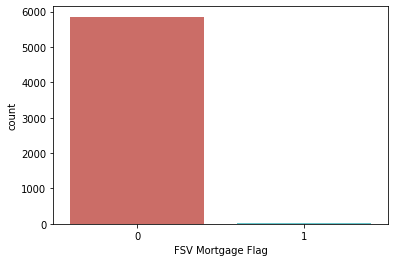

count    4106.000000
mean        0.001705
std         0.041259
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: FSV Mortgage Flag, dtype: float64
count    1761.000000
mean        0.001704
std         0.041251
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: FSV Mortgage Flag, dtype: float64


<Figure size 432x288 with 0 Axes>

In [388]:
sns.countplot(x='FSV Mortgage Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')

print(prod_train['FSV Mortgage Flag'].describe())
print(prod_test['FSV Mortgage Flag'].describe())
# Will save the time for this and set the probability to be 0 (0.0017)

In [389]:
# Will save the time for this and set the probability to be (0.0017
prod_train_out['Pred_Prob_Mortgage1']=0.0017
prod_test_out['Pred_Prob_Mortgage1']=0.0017

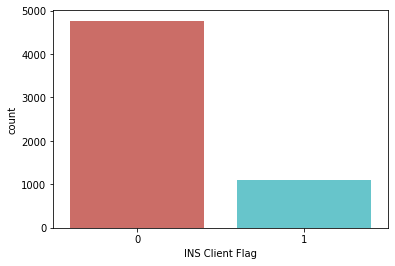

count    4106.000000
mean        0.188992
std         0.391550
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: INS Client Flag, dtype: float64
count    1761.000000
mean        0.184554
std         0.388046
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: INS Client Flag, dtype: float64


<Figure size 432x288 with 0 Axes>

In [390]:

sns.countplot(x='INS Client Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')

print(prod_train['INS Client Flag'].describe())
print(prod_test['INS Client Flag'].describe())

In [391]:
Modeling_X=prod_train[X_list]
Test_X=prod_test[X_list]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'INS Client Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'INS Client Flag']

logit_model_INS=sm.Logit(y_train,X_train)
result=logit_model_INS.fit()
print(result.summary2())

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


         Current function value: 0.460940
         Iterations: 35
                                          Results: Logit
Model:                         Logit                       Pseudo R-squared:            0.049     
Dependent Variable:            INS Client Flag             AIC:                         3871.2413 
Date:                          2020-05-30 10:21            BIC:                         4143.0101 
No. Observations:              4106                        Log-Likelihood:              -1892.6   
Df Model:                      42                          LL-Null:                     -1990.4   
Df Residuals:                  4063                        LLR p-value:                 1.1133e-21
Converged:                     0.0000                      Scale:                       1.0000    
No. Iterations:                35.0000                                                            
-------------------------------------------------------------------------------------

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1436
           1       0.00      0.00      0.00       325

    accuracy                           0.82      1761
   macro avg       0.41      0.50      0.45      1761
weighted avg       0.66      0.82      0.73      1761

Accuracy of this classifier on test set: 0.82
0.8110083767978505
[[1436    0]
 [ 325    0]]


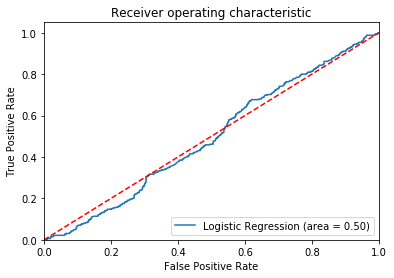

In [392]:
X_list_final=['m_TenureYr','m_OccupationMissing',
      'm_PrimaryMember', 'm_RenterFlag',
         'm_Income', 'Ed_Graduated School','Ed_High School','Ed_Some College','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'INS Client Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'INS Client Flag']

logregINS = LogisticRegression()
logregINS.fit(X_train,y_train )

y_pred = logregINS.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(logregINS.score(X_test, y_test)))


from sklearn.model_selection import cross_val_score
scores = cross_val_score(logregINS, X_train, y_train, cv=3)
print(scores.mean())
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logregINS.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregINS.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [393]:
DT_INS = DecisionTreeClassifier(max_depth=15, min_samples_split=50,min_samples_leaf=20,random_state=0)
print(cross_val_score(DT_INS, X_train, y_train, cv=3))

RF_INS = RandomForestClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(RF_INS, X_train, y_train, cv=3))

ET_INS = ExtraTreesClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(ET_INS, X_train, y_train, cv=3))

# Random Foreast has better accuracy

[0.79620161 0.81081081 0.8004386 ]
[0.81081081 0.81081081 0.81140351]
[0.81081081 0.81081081 0.81140351]


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1436
           1       0.00      0.00      0.00       325

    accuracy                           0.82      1761
   macro avg       0.41      0.50      0.45      1761
weighted avg       0.66      0.82      0.73      1761

Accuracy of this classifier on test set: 0.82
0.8110083767978505


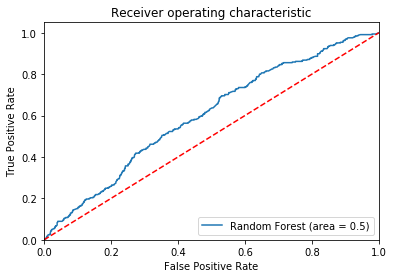

In [394]:
X_list_final=['m_TenureYr','m_OccupationMissing',
      'm_PrimaryMember', 'm_RenterFlag',
         'm_Income', 'Ed_Graduated School','Ed_High School','Ed_Some College','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'INS Client Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'INS Client Flag']

RF_INS.fit(X_train,y_train )

y_pred = RF_INS.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(RF_INS.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(RF_INS, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, RF_INS.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RF_INS.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_INS_ROC')
plt.show()

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1436
           1       0.00      0.00      0.00       325

    accuracy                           0.82      1761
   macro avg       0.41      0.50      0.45      1761
weighted avg       0.66      0.82      0.73      1761

Accuracy of this classifier on test set: 0.82
0.8110083767978505


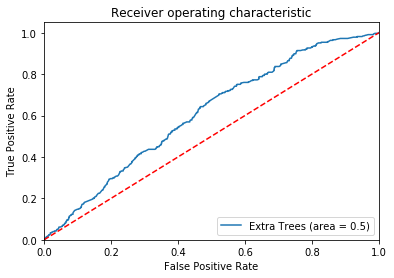

In [395]:
X_list_final=['m_TenureYr','m_OccupationMissing',
      'm_PrimaryMember', 'm_RenterFlag',
         'm_Income', 'Ed_Graduated School','Ed_High School','Ed_Some College','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'INS Client Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'INS Client Flag']

ET_INS.fit(X_train,y_train )

y_pred = ET_INS.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(ET_INS.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(ET_INS, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, ET_INS.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, ET_INS.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Extra Trees (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ET_INS_ROC')
plt.show()

In [396]:
# not very happy with Random Forest and Extra Trees on AUC. Trying Boosting.
from sklearn.ensemble import AdaBoostClassifier

bdt_real_INS = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=200,
    learning_rate=1)

print(cross_val_score(bdt_real_INS, X_train, y_train, cv=3))

[0.72899927 0.73119065 0.70394737]


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1436
           1       0.24      0.15      0.18       325

    accuracy                           0.76      1761
   macro avg       0.53      0.52      0.52      1761
weighted avg       0.72      0.76      0.73      1761

Accuracy of this classifier on test set: 0.76
0.7274708919445761


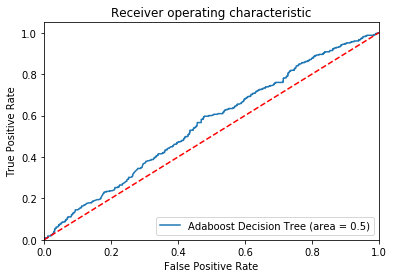

In [397]:
X_list_final=['m_TenureYr','m_OccupationMissing',
      'm_PrimaryMember', 'm_RenterFlag',
         'm_Income', 'Ed_Graduated School','Ed_High School','Ed_Some College','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'INS Client Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'INS Client Flag']

bdt_real_INS.fit(X_train,y_train )

y_pred = bdt_real_INS.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(bdt_real_INS.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(bdt_real_INS, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, bdt_real_INS.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, bdt_real_INS.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Adaboost Decision Tree (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('bdt_real_INS')
plt.show()

In [398]:
from sklearn.ensemble import GradientBoostingClassifier

GB_INS = GradientBoostingClassifier(learning_rate=1,min_samples_split=50, min_samples_leaf=25, n_estimators=200,random_state=0)
print(cross_val_score(GB_INS, X_train, y_train, cv=3))

[0.78305332 0.78743608 0.76900585]


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1436
           1       0.25      0.06      0.09       325

    accuracy                           0.79      1761
   macro avg       0.53      0.51      0.49      1761
weighted avg       0.71      0.79      0.74      1761

Accuracy of this classifier on test set: 0.79
0.7798317520934875


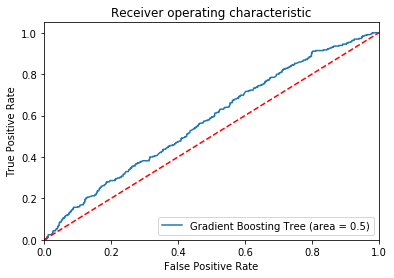

In [399]:
X_list_final=['m_TenureYr','m_OccupationMissing',
      'm_PrimaryMember', 'm_RenterFlag',
         'm_Income', 'Ed_Graduated School','Ed_High School','Ed_Some College','m_AutoRenew'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'INS Client Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'INS Client Flag']

GB_INS.fit(X_train,y_train )

y_pred = GB_INS.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(GB_INS.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(GB_INS, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, GB_INS.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, GB_INS.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting Tree (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GB_INS')
plt.show()

In [400]:
#After comparing multiple models, extra trees is the better model for Insurance product.
ET_INS.fit(X_train, y_train)
y_train_pred= pd.DataFrame(ET_INS.predict_proba(X_train), columns = ['Pred_Prob_INS0','Pred_Prob_INS1']) 
y_test_pred = pd.DataFrame(ET_INS.predict_proba(X_test), columns = ['Pred_Prob_INS0','Pred_Prob_INS1']) 
#print(y_test_pred.head(10))
prod_train.reset_index(drop=True, inplace=True)
y_train_pred.reset_index(drop=True, inplace=True)
prod_test.reset_index(drop=True, inplace=True)
y_test_pred.reset_index(drop=True, inplace=True)
prod_train_out=pd.concat([prod_train_out, y_train_pred],axis=1)
prod_test_out=pd.concat([prod_test_out, y_test_pred],axis=1)

#cancel_out=pd.concat([cancel_train_out, cancel_test_out],axis=0)
# only keep the active member prediction for segementation.
#cancel_out_active=cancel_out[cancel_out['Voluntary Cancel Flag']==0]
prod_test_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out_check.csv')
#print(cancel_out_active['Household Key'].describe())


In [401]:
#Trying using all of the features to see if that will improve
Modeling_X2=prod_train[X_list]
Test_X2=prod_test[X_list]

X_train2 = sm.add_constant(Modeling_X2)
y_train2 = prod_train.loc[:,'INS Client Flag']

X_test2 = sm.add_constant(Test_X2)
y_test2 = prod_test.loc[:,'INS Client Flag']

DT_INS2 = DecisionTreeClassifier(max_depth=15, min_samples_split=50,min_samples_leaf=20,random_state=0)
print(cross_val_score(DT_INS2, X_train2, y_train2, cv=3))

RF_INS2 = RandomForestClassifier(n_estimators=100, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(RF_INS2, X_train2, y_train2, cv=3))

ET_INS2 = ExtraTreesClassifier(n_estimators=100, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(ET_INS2, X_train2, y_train2, cv=3))

# Random Foreast has better accuracy

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


[0.79547115 0.80715851 0.7880117 ]
[0.81081081 0.81081081 0.81140351]
[0.81081081 0.81081081 0.81140351]


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1436
           1       0.00      0.00      0.00       325

    accuracy                           0.82      1761
   macro avg       0.41      0.50      0.45      1761
weighted avg       0.66      0.82      0.73      1761

Accuracy of this classifier on test set: 0.82
0.8110083767978505


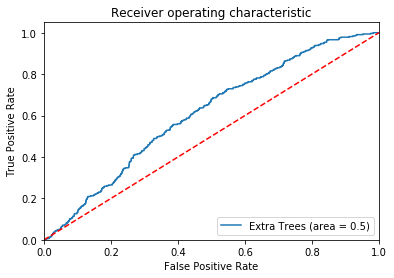

In [402]:
Modeling_X2=prod_train[X_list]
Test_X2=prod_test[X_list]

X_train2 = sm.add_constant(Modeling_X2)
y_train2 = prod_train.loc[:,'INS Client Flag']

X_test2 = sm.add_constant(Test_X2)
y_test2 = prod_test.loc[:,'INS Client Flag']

ET_INS2.fit(X_train2,y_train2 )

y_pred2 = ET_INS2.predict(X_test2)

from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred2))

print('Accuracy of this classifier on test set: {:.2f}'.format(ET_INS2.score(X_test2, y_test2)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(ET_INS2, X_train2, y_train2, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test2, ET_INS2.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test2, ET_INS2.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Extra Trees (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ET_INS_ROC')
plt.show()

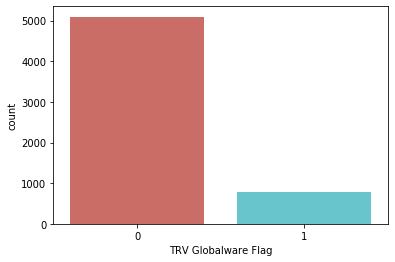

<Figure size 432x288 with 0 Axes>

In [403]:
# Move on to the Travelware product
sns.countplot(x='TRV Globalware Flag',data=Profile_activeset,palette='hls')
plt.show()
plt.savefig('count_plot')

In [404]:
########### Feature selection on Travelware Flag  #############

Modeling_X=prod_train[X_list]
Test_X=prod_test[X_list]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'TRV Globalware Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'TRV Globalware Flag']

logit_model_TRV=sm.Logit(y_train,X_train)
result=logit_model_TRV.fit()
print(result.summary2())


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


         Current function value: 0.383473
         Iterations: 35
                                         Results: Logit
Model:                        Logit                        Pseudo R-squared:          0.034     
Dependent Variable:           TRV Globalware Flag          AIC:                       3235.0844 
Date:                         2020-05-30 10:22             BIC:                       3506.8532 
No. Observations:             4106                         Log-Likelihood:            -1574.5   
Df Model:                     42                           LL-Null:                   -1630.1   
Df Residuals:                 4063                         LLR p-value:               3.7682e-08
Converged:                    0.0000                       Scale:                     1.0000    
No. Iterations:               35.0000                                                           
------------------------------------------------------------------------------------------------
     

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1546
           1       0.00      0.00      0.00       215

    accuracy                           0.88      1761
   macro avg       0.44      0.50      0.47      1761
weighted avg       0.77      0.88      0.82      1761

Accuracy of this classifier on test set: 0.88
0.8643449637404118


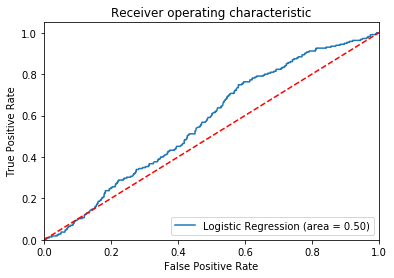

In [405]:
X_list_final=['m_TenureYr','m_memberage', 
         'm_IncomeMissing', 'Ed_Graduated School', 'Ed_Completed College',
            'Ed_Some College'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'TRV Globalware Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'TRV Globalware Flag']

logregTRV = LogisticRegression()
logregTRV.fit(X_train,y_train )

y_pred = logregTRV.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(logregTRV.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logregTRV, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logregTRV.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logregTRV.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('TRV_ROC')
plt.show()

In [406]:
DT_TRV = DecisionTreeClassifier(max_depth=15, min_samples_split=50,min_samples_leaf=20,random_state=0)
print(cross_val_score(DT_TRV, X_train, y_train, cv=3))

RF_TRV = RandomForestClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(RF_TRV, X_train, y_train, cv=3))

ET_TRV = ExtraTreesClassifier(n_estimators=15, max_depth=15,min_samples_split=50,min_samples_leaf=20, random_state=0)
print(cross_val_score(ET_TRV, X_train, y_train, cv=3))

GB_TRV = GradientBoostingClassifier(learning_rate=1,min_samples_split=50, min_samples_leaf=25, n_estimators=200,random_state=0)
print(cross_val_score(GB_TRV, X_train, y_train, cv=3))

bdt_real_TRV = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,min_samples_split=50, min_samples_leaf=25,), n_estimators=200,learning_rate=1)
print(cross_val_score(bdt_real_TRV, X_train, y_train, cv=3))

[0.8641344  0.8641344  0.86476608]
[0.8641344  0.8641344  0.86476608]
[0.8641344  0.8641344  0.86476608]
[0.83345508 0.83710738 0.84429825]
[0.79985391 0.79254931 0.78947368]


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1546
           1       0.00      0.00      0.00       215

    accuracy                           0.88      1761
   macro avg       0.44      0.50      0.47      1761
weighted avg       0.77      0.88      0.82      1761

Accuracy of this classifier on test set: 0.88
0.8643449637404118


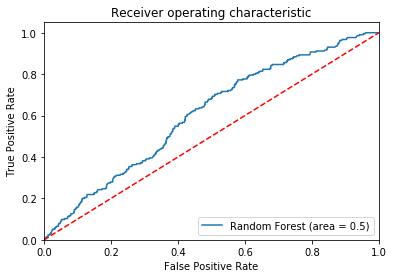

In [407]:
X_list_final=['m_TenureYr','m_memberage', 
         'm_IncomeMissing', 'Ed_Graduated School', 'Ed_Completed College',
            'Ed_Some College'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'TRV Globalware Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'TRV Globalware Flag']

RF_TRV.fit(X_train,y_train )

y_pred = RF_TRV.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(RF_TRV.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(RF_TRV, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, RF_TRV.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, RF_TRV.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('TRV_INS_ROC')
plt.show()

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1546
           1       0.00      0.00      0.00       215

    accuracy                           0.88      1761
   macro avg       0.44      0.50      0.47      1761
weighted avg       0.77      0.88      0.82      1761

Accuracy of this classifier on test set: 0.88
0.8643449637404118


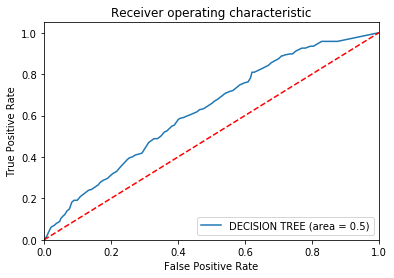

In [408]:
X_list_final=['m_TenureYr','m_memberage', 
         'm_IncomeMissing', 'Ed_Graduated School', 'Ed_Completed College',
            'Ed_Some College'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'TRV Globalware Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'TRV Globalware Flag']

DT_TRV.fit(X_train,y_train )

y_pred = DT_TRV.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(DT_TRV.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(DT_TRV, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, DT_TRV.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, DT_TRV.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DECISION TREE (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('TRV_ROC')
plt.show()

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1546
           1       0.00      0.00      0.00       215

    accuracy                           0.88      1761
   macro avg       0.44      0.50      0.47      1761
weighted avg       0.77      0.88      0.82      1761

Accuracy of this classifier on test set: 0.88
0.8643449637404118


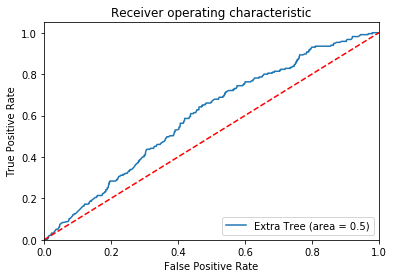

In [409]:
X_list_final=['m_TenureYr','m_memberage', 
         'm_IncomeMissing', 'Ed_Graduated School', 'Ed_Completed College',
            'Ed_Some College'
]

Modeling_X=prod_train[X_list_final]
Test_X=prod_test[X_list_final]

X_train = sm.add_constant(Modeling_X)
y_train = prod_train.loc[:,'TRV Globalware Flag']

X_test = sm.add_constant(Test_X)
y_test = prod_test.loc[:,'TRV Globalware Flag']

ET_TRV.fit(X_train,y_train )

y_pred = ET_TRV.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print('Accuracy of this classifier on test set: {:.2f}'.format(ET_TRV.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(ET_TRV, X_train, y_train, cv=3)
print(scores.mean())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, ET_TRV.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, ET_TRV.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Extra Tree (area = %0.1f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('TRV_ROC')
plt.show()

In [410]:
# Random forest is better model for travel ware.

RF_TRV.fit(X_train, y_train)
y_train_pred= pd.DataFrame(RF_TRV.predict_proba(X_train), columns = ['Pred_Prob_TRV0','Pred_Prob_TRV1']) 
y_test_pred = pd.DataFrame(RF_TRV.predict_proba(X_test), columns = ['Pred_Prob_TRV0','Pred_Prob_TRV1']) 
#print(y_test_pred.head(10))
prod_train.reset_index(drop=True, inplace=True)
y_train_pred.reset_index(drop=True, inplace=True)
prod_test.reset_index(drop=True, inplace=True)
y_test_pred.reset_index(drop=True, inplace=True)
prod_train_out=pd.concat([prod_train_out, y_train_pred],axis=1)
prod_test_out=pd.concat([prod_test_out, y_test_pred],axis=1)

#cancel_out=pd.concat([cancel_train_out, cancel_test_out],axis=0)
# only keep the active member prediction for segementation.
#cancel_out_active=cancel_out[cancel_out['Voluntary Cancel Flag']==0]
#prod_test_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out_check.csv')
#print(cancel_out_active['Household Key'].describe())

In [411]:
prod_out=pd.concat([prod_train_out, prod_test_out],axis=0)
prod_out.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\prod_out.csv')

In [413]:
cancel_out_active=cancel_out[cancel_out['Voluntary Cancel Flag']==0]
cancel_out_active.to_csv(r'C:\Mark_Mao\MLAL_capstone\CleanSet\cancel_out_active.csv')

In [414]:
# Note: Probability of Voluntary cancallation is a good model to identify both event and non-event
# and has a very good separation between 0/1.

# The resst of the model is good at predicting non-event (not buying product) but 
# not very good at predicting the event (buying product). Not great at separating 0/1.
# It is still fine to identify certain chararistics that may lead to higher chance to buying AAA products.
